
**XRP (Ripple)**

**Project Title: FutureCoin: Machine Learning-Based Crypto Price Prediction**

**1. Project Statement and Outcomes:**


1.The Cryptocurrency Price Prediction Using Machine Learning project aims to predict future cryptocurrency prices using time-series forecasting. The system will preprocess historical data, build predictive models, and visualize trends to offer valuable insights into future price movements.


2.A system that accurately predicts future cryptocurrency prices using time-series forecasting. It will offer valuable insights into market trends by analyzing historical data and visualizing predicted price movements, helping users make informed decisions in the cryptocurrency market.

**Milestone 2:**

Week 3-4: Modal Architecture, Training, Evaluation:

● Identify and create relevant features for time-series forecasting (e.g., moving averages, rolling statistics).

● Train machine learning models for time-series forecasting to predict future prices.

● Tune hyperparameters and validate model performance using standard metrics like MSE and MAE.


Fold 1: Train=(8852, 10, 9), Val=(8852, 10, 9)
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 1: MSE=0.000001, MAE=0.000511, R2=0.998336

Fold 2: Train=(17714, 10, 9), Val=(8852, 10, 9)
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 2: MSE=0.000017, MAE=0.001966, R2=0.998478

Fold 3: Train=(26576, 10, 9), Val=(8852, 10, 9)
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3: MSE=0.000009, MAE=0.001943, R2=0.997361

Fold 4: Train=(35438, 10, 9), Val=(8852, 10, 9)
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 4: MSE=0.000001, MAE=0.000708, R2=0.995909

Fold 5: Train=(44300, 10, 9), Val=(8852, 10, 9)
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 5: MSE=0.000002, MAE=0.000733, R2=0.995187

=== Average CV Metrics ===
Average MSE: 6.042126233296585e-06
Average MAE: 0.0011723420699127018
Average R2 : 0.9970539569854736
416/416 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== Final Test Metrics ===
MSE: 6.824373849667609e-05
MAE: 0.005136571358889341
R2 : 0.9990720152854919


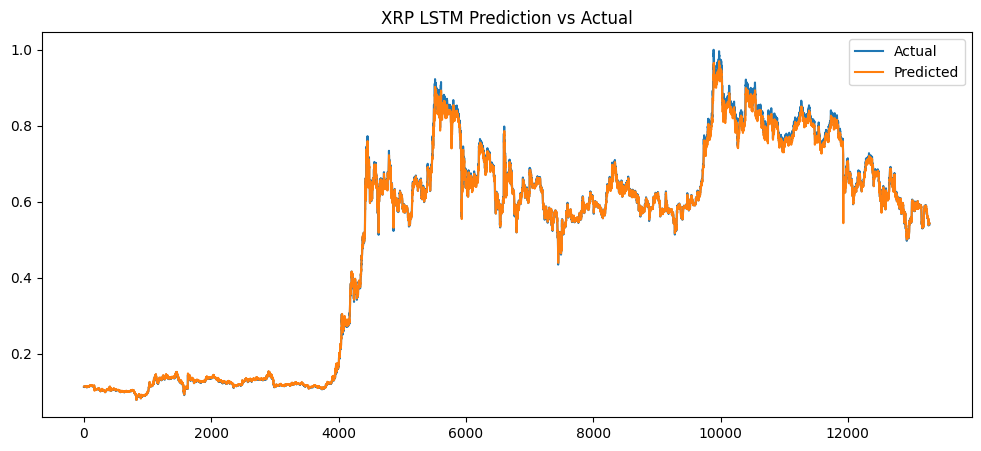

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# Load CSV
# -----------------------------
df = pd.read_csv("/content/XRP_cleaned_scaled.csv")

# Convert timestamp properly
df["Open Time"] = pd.to_datetime(df["Open Time"])

# Select numeric features only (all except timestamp)
features = df.drop(columns=["Open Time"]).values.astype("float32")

# Target = Close price
target = df["Close"].values.astype("float32")

# -----------------------------
# Sliding window function
# -----------------------------
def make_windows(X, y, window):
    X_list, y_list = [], []
    for i in range(len(X) - window):
        X_list.append(X[i:i+window])
        y_list.append(y[i+window])
    return np.array(X_list), np.array(y_list)

WINDOW = 10
N_SPLITS = 5

# -----------------------------
# Train-test split (last 20% as test)
# -----------------------------
test_size = int(0.2 * len(features))

X_train_raw = features[:-test_size]
y_train_raw = target[:-test_size]

X_test_raw = features[-test_size:]
y_test_raw = target[-test_size:]

# -----------------------------
# Cross-validation setup
# -----------------------------
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

mse_scores, mae_scores, r2_scores = [], [], []

# -----------------------------
# Cross-validation loop
# -----------------------------
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_raw), 1):

    X_tr_seq, y_tr_seq = make_windows(X_train_raw[train_idx], y_train_raw[train_idx], WINDOW)
    X_val_seq, y_val_seq = make_windows(X_train_raw[val_idx], y_train_raw[val_idx], WINDOW)

    print(f"\nFold {fold}: Train={X_tr_seq.shape}, Val={X_val_seq.shape}")

    model = Sequential([
        Input(shape=(WINDOW, X_tr_seq.shape[2])),
        LSTM(50, activation="tanh"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")

    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    model.fit(
        X_tr_seq, y_tr_seq,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop],
        verbose=0
    )

    y_val_pred = model.predict(X_val_seq)

    mse = mean_squared_error(y_val_seq, y_val_pred)
    mae = mean_absolute_error(y_val_seq, y_val_pred)
    r2 = r2_score(y_val_seq, y_val_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: MSE={mse:.6f}, MAE={mae:.6f}, R2={r2:.6f}")

# -----------------------------
# Average CV Scores
# -----------------------------
print("\n=== Average CV Metrics ===")
print("Average MSE:", np.mean(mse_scores))
print("Average MAE:", np.mean(mae_scores))
print("Average R2 :", np.mean(r2_scores))

# -----------------------------
# Train final model on all training data
# -----------------------------
X_train_final, y_train_final = make_windows(X_train_raw, y_train_raw, WINDOW)
X_test_final, y_test_final = make_windows(X_test_raw, y_test_raw, WINDOW)

final_model = Sequential([
    Input(shape=(WINDOW, X_train_final.shape[2])),
    LSTM(50, activation="tanh"),
    Dense(1)
])

final_model.compile(optimizer="adam", loss="mse")

early_stop_final = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

final_model.fit(
    X_train_final, y_train_final,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_final, y_test_final),
    callbacks=[early_stop_final],
    verbose=0
)

# -----------------------------
# Final evaluation
# -----------------------------
y_pred_final = final_model.predict(X_test_final)

print("\n=== Final Test Metrics ===")
print("MSE:", mean_squared_error(y_test_final, y_pred_final))
print("MAE:", mean_absolute_error(y_test_final, y_pred_final))
print("R2 :", r2_score(y_test_final, y_pred_final))

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test_final, label="Actual")
plt.plot(y_pred_final, label="Predicted")
plt.legend()
plt.title("XRP LSTM Prediction vs Actual")
plt.show()


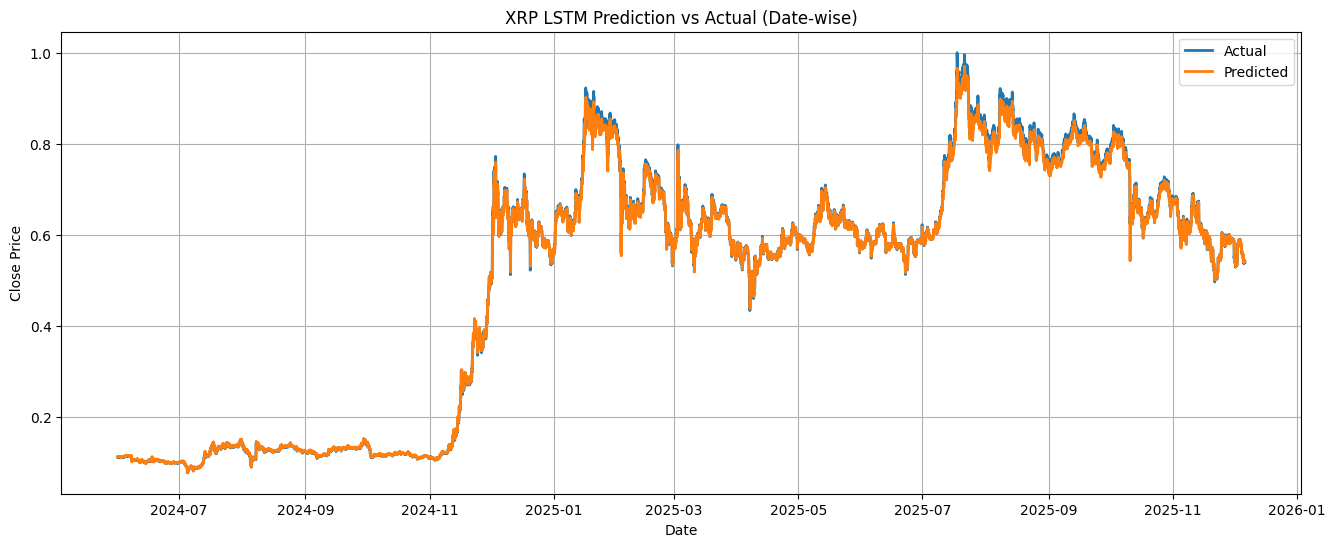

In [2]:
# Get the corresponding dates for the test set
test_dates = df["Open Time"].iloc[-test_size + WINDOW:].reset_index(drop=True)

# Plot date-wise
plt.figure(figsize=(16,6))
plt.plot(test_dates, y_test_final, label="Actual", linewidth=2)
plt.plot(test_dates, y_pred_final, label="Predicted", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("XRP LSTM Prediction vs Actual (Date-wise)")
plt.legend()
plt.grid(True)
plt.show()
